## Stance Detection using Fake News Challenge Dataset
### by Gyanesh Pandey (SJSU ID: 012506936)

### Here are the steps taken to predict stance using the Fake News Challenge dataset
* Feature Selection
* Reading Dataset
* Test/Train Model
* Score
* Generate Features
* K Fold Classifier for choosing Model Efficiency

## Customizing Stance Detection to our original Fake News Dataset 

<img src="NLP_Pipeline_for_Alternus_Vera.png"/>


## Feature Selection

In [22]:
import os
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import feature_extraction
from tqdm import tqdm


In [23]:
_wnl = nltk.WordNetLemmatizer()


def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(s):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric

    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


def gen_or_load_feats(feat_fn, headlines, bodies, feature_file):
    if not os.path.isfile(feature_file):
        feats = feat_fn(headlines, bodies)
        np.save(feature_file, feats)

    return np.load(feature_file)

In [24]:
def word_overlap_features(headlines, bodies):
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        clean_headline = get_tokenized_lemmas(clean_headline)
        clean_body = get_tokenized_lemmas(clean_body)
        features = [
            len(set(clean_headline).intersection(clean_body)) / float(len(set(clean_headline).union(clean_body)))]
        X.append(features)
        i = i+1
    return X

In [25]:

def refuting_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        # 'refute',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_headline = get_tokenized_lemmas(clean_headline)
        features = [1 if word in clean_headline else 0 for word in _refuting_words]
        X.append(features)
    return X

In [26]:
def polarity_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]

    def calculate_polarity(text):
        tokens = get_tokenized_lemmas(text)
        return sum([t in _refuting_words for t in tokens]) % 2
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        features = []
        features.append(calculate_polarity(clean_headline))
        features.append(calculate_polarity(clean_body))
        X.append(features)
    return np.array(X)

In [27]:

def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output

In [28]:

def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join(remove_stopwords(text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features

In [29]:

def hand_features(headlines, bodies):

    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def binary_co_occurence_stops(headline, body):
        # Count how many times a token in the title
        # appears in the body text. Stopwords in the title
        # are ignored.
        bin_count = 0
        bin_count_early = 0
        for headline_token in remove_stopwords(clean(headline).split(" ")):
            if headline_token in clean(body):
                bin_count += 1
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []
        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)
        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        X.append(binary_co_occurence(headline, body)
                 + binary_co_occurence_stops(headline, body)
                 + count_grams(headline, body))


    return X

## Fake News Challenge

In [30]:
import sys
import numpy as np
import random
import re
import argparse

from collections import defaultdict
from sklearn.ensemble import GradientBoostingClassifier
from csv import DictReader

#Import from other files
from utils.dataset import DataSet
from utils.generate_test_splits import kfold_split, get_stances_for_folds
from utils.score import report_score, LABELS, score_submission
from utils.system import parse_params, check_version

### Reading FNC Dataset

In [40]:
class DataSet():
    def __init__(self, name="train", path="fnc-1"):
        self.path = path

        print("Reading dataset")
        bodies = name+"_bodies.csv"
        stances = name+"_stances.csv"

        self.stances = self.read(stances)
        
        articles = self.read(bodies)
        self.articles = dict()

        #make the body ID an integer value
        for s in self.stances:
            s['Body ID'] = int(s['Body ID'])
        
        #copy all bodies into a dictionary
        for article in articles:
            self.articles[int(article['Body ID'])] = article['articleBody']

        print("Total stances: " + str(len(self.stances)))
        print("Total bodies: " + str(len(self.articles)))



    def read(self,filename):
        rows = []
        with open(self.path + "/" + filename, "rt", encoding='utf-8-sig') as table:
            r = DictReader(table)
            for line in r:
                rows.append(line)
        return rows

### Generate test splits 

In [41]:
def generate_hold_out_split (dataset, training = 0.8, base_dir="splits"):
    r = random.Random()
    r.seed(1489215)

    article_ids = list(dataset.articles.keys())  # get a list of article ids
    r.shuffle(article_ids)  # and shuffle that list


    training_ids = article_ids[:int(training * len(article_ids))]
    hold_out_ids = article_ids[int(training * len(article_ids)):]

    # write the split body ids out to files for future use
    with open(base_dir+ "/"+ "training_ids.txt", "w+") as f:
        f.write("\n".join([str(id) for id in training_ids]))

    with open(base_dir+ "/"+ "hold_out_ids.txt", "w+") as f:
        f.write("\n".join([str(id) for id in hold_out_ids]))



def read_ids(file,base):
    ids = []
    with open(base+"/"+file,"r") as f:
        for line in f:
           ids.append(int(line))
        return ids


def kfold_split(dataset, training = 0.8, n_folds = 10, base_dir="splits"):
    if not (os.path.exists(base_dir+ "/"+ "training_ids.txt")
            and os.path.exists(base_dir+ "/"+ "hold_out_ids.txt")):
        generate_hold_out_split(dataset,training,base_dir)

    training_ids = read_ids("training_ids.txt", base_dir)
    hold_out_ids = read_ids("hold_out_ids.txt", base_dir)

    folds = []
    for k in range(n_folds):
        folds.append(training_ids[int(k*len(training_ids)/n_folds):int((k+1)*len(training_ids)/n_folds)])

    return folds,hold_out_ids


def get_stances_for_folds(dataset,folds,hold_out):
    stances_folds = defaultdict(list)
    stances_hold_out = []
    for stance in dataset.stances:
        if stance['Body ID'] in hold_out:
            stances_hold_out.append(stance)
        else:
            fold_id = 0
            for fold in folds:
                if stance['Body ID'] in fold:
                    stances_folds[fold_id].append(stance)
                fold_id += 1

    return stances_folds,stances_hold_out

### Scoring using a customized Confusion Matrix

In [42]:
#Adapted from https://github.com/FakeNewsChallenge/fnc-1/blob/master/scorer.py
#Original credit - @bgalbraith

LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score


if __name__ == "__main__":
    actual = [0,0,0,0,1,1,0,3,3]
    predicted = [0,0,0,0,1,1,2,3,3]

    report_score([LABELS[e] for e in actual],[LABELS[e] for e in predicted])

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     4     |     0     |     1     |     0     |
-------------------------------------------------------------
| disagree  |     0     |     2     |     0     |     0     |
-------------------------------------------------------------
|  discuss  |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     2     |
-------------------------------------------------------------
Score: 6.75 out of 7.5	(90.0%)


### Systems

In [193]:
def parse_params():
    parser = argparse.ArgumentParser(description='FakeNews Stance Detection')
    parser.add_argument('-c', '--clean-cache', action='store_true', default=False, help="clean cache files")
#    params = parser.parse_args()
#    if not params.clean_cache:
#        return

    dr = "features"
    for f in os.listdir(dr):
        if re.search('\.npy$', f):
            fname = os.path.join(dr, f)
            os.remove(fname)
    for f in ['hold_out_ids.txt', 'training_ids.txt']:
        fname = os.path.join('splits', f)
        if os.path.isfile(fname):
            os.remove(fname)
    print("All clear")

def check_version():
    if sys.version_info.major < 3:
        sys.stderr.write('Please use Python version 3 and above\n')
        sys.exit(1)

### Generating features for the input headline and body

In [44]:
def generate_features(stances,dataset,name):
    h, b, y = [],[],[]

    for stance in stances:
        y.append(LABELS.index(stance['Stance']))
        h.append(stance['Headline'])
        b.append(dataset.articles[stance['Body ID']])

    X_overlap = gen_or_load_feats(word_overlap_features, h, b, "features/overlap."+name+".npy")
    X_refuting = gen_or_load_feats(refuting_features, h, b, "features/refuting."+name+".npy")
    X_polarity = gen_or_load_feats(polarity_features, h, b, "features/polarity."+name+".npy")
    X_hand = gen_or_load_feats(hand_features, h, b, "features/hand."+name+".npy")

    X = np.c_[X_hand, X_polarity, X_refuting, X_overlap]
    return X,y



In [75]:
if __name__ == "__main__":
    check_version()
    parse_params()


    #Load the training dataset and generate folds
    d = DataSet()
    folds,hold_out = kfold_split(d,n_folds=10)
    fold_stances, hold_out_stances = get_stances_for_folds(d,folds,hold_out)
    
        # Load the competition dataset
    competition_dataset = DataSet("competition_test")
    X_competition, y_competition = generate_features(competition_dataset.stances, competition_dataset, "competition")

    Xs = dict()
    ys = dict()

    # Load/Precompute all features now
    X_holdout,y_holdout = generate_features(hold_out_stances,d,"holdout")
    for fold in fold_stances:
        Xs[fold],ys[fold] = generate_features(fold_stances[fold],d,str(fold))


    best_score = 0
    best_fold = None
    
# Classifier for each fold
## Uncomment this for loop code when you run this notebook for the first time. Takes over 30 mins to run.
    for fold in fold_stances:
        ids = list(range(len(folds)))
        del ids[fold]

        X_train = np.vstack(tuple([Xs[i] for i in ids]))
        y_train = np.hstack(tuple([ys[i] for i in ids]))

        X_test = Xs[fold]
        y_test = ys[fold]

        clf = GradientBoostingClassifier(n_estimators=200, random_state=14128, verbose=False)
        clf.fit(X_train, y_train)

        predicted = [LABELS[int(a)] for a in clf.predict(X_test)]
        actual = [LABELS[int(a)] for a in y_test]

        fold_score, _ = score_submission(actual, predicted)
        max_fold_score, _ = score_submission(actual, actual)

        score = fold_score/max_fold_score

        print("Score for fold "+ str(fold) + " was - " + str(score))
        if score > best_score:
            best_score = score
            best_fold = clf
#-----------------

    #Run on Holdout set and report the final score on the holdout set
    predicted = [LABELS[int(a)] for a in best_fold.predict(X_holdout)]
    actual = [LABELS[int(a)] for a in y_holdout]

    print("Scores on the dev set")
    report_score(actual,predicted)
    print("")
    print("")

    #Run on competition dataset
    predicted = [LABELS[int(a)] for a in best_fold.predict(X_competition)]
    actual = [LABELS[int(a)] for a in y_competition]

    print("Scores on the test set")
    report_score(actual,predicted)
            

All clear
Reading dataset
Total stances: 49972
Total bodies: 1683
Reading dataset



0it [00:00, ?it/s]
32it [00:00, 315.20it/s]

Total stances: 25413
Total bodies: 904



65it [00:00, 318.38it/s]
95it [00:00, 312.48it/s]
134it [00:00, 331.81it/s]
164it [00:00, 319.21it/s]
201it [00:00, 331.76it/s]
240it [00:00, 344.39it/s]
273it [00:00, 326.92it/s]
305it [00:00, 300.27it/s]
337it [00:01, 304.45it/s]
373it [00:01, 318.82it/s]
405it [00:01, 315.25it/s]
440it [00:01, 323.67it/s]
473it [00:01, 310.86it/s]
505it [00:01, 309.62it/s]
543it [00:01, 326.62it/s]
576it [00:01, 305.87it/s]
611it [00:01, 315.63it/s]
649it [00:02, 331.92it/s]
683it [00:02, 314.95it/s]
716it [00:02, 302.47it/s]
750it [00:02, 312.03it/s]
789it [00:02, 331.84it/s]
828it [00:02, 347.34it/s]
864it [00:02, 340.45it/s]
899it [00:02, 335.27it/s]
933it [00:02, 324.73it/s]
969it [00:02, 332.85it/s]
1003it [00:03, 295.19it/s]
1034it [00:03, 285.73it/s]
1064it [00:03, 272.67it/s]
1092it [00:03, 267.80it/s]
1121it [00:03, 272.98it/s]
1149it [00:03, 243.34it/s]
1179it [00:03, 257.82it/s]
1207it [00:03, 261.37it/s]
1236it [00:04, 268.25it/s]
1264it [00:04, 271.50it/s]
1293it [00:04, 274.32it/s]
13

18004it [00:59, 365.05it/s]
18045it [00:59, 373.95it/s]
18083it [00:59, 324.17it/s]
18122it [00:59, 339.08it/s]
18158it [01:00, 338.35it/s]
18196it [01:00, 343.66it/s]
18231it [01:00, 323.73it/s]
18278it [01:00, 356.49it/s]
18316it [01:00, 356.88it/s]
18353it [01:00, 360.21it/s]
18398it [01:00, 380.97it/s]
18437it [01:00, 378.68it/s]
18479it [01:00, 388.42it/s]
18524it [01:00, 404.87it/s]
18565it [01:01, 398.23it/s]
18606it [01:01, 365.15it/s]
18649it [01:01, 382.26it/s]
18688it [01:01, 380.38it/s]
18729it [01:01, 376.58it/s]
18768it [01:01, 370.76it/s]
18807it [01:01, 375.15it/s]
18845it [01:01, 369.19it/s]
18885it [01:01, 369.21it/s]
18932it [01:02, 388.85it/s]
18977it [01:02, 405.07it/s]
19018it [01:02, 403.43it/s]
19059it [01:02, 400.02it/s]
19100it [01:02, 395.02it/s]
19141it [01:02, 390.91it/s]
19181it [01:02, 363.12it/s]
19218it [01:02, 346.46it/s]
19254it [01:02, 341.09it/s]
19290it [01:03, 339.23it/s]
19325it [01:03, 338.23it/s]
19360it [01:03, 329.03it/s]
19399it [01:03, 340.

10426it [00:30, 313.22it/s]
10458it [00:30, 306.07it/s]
10493it [00:30, 317.79it/s]
10535it [00:30, 342.67it/s]
10571it [00:30, 342.75it/s]
10616it [00:31, 368.51it/s]
10654it [00:31, 342.38it/s]
10690it [00:31, 347.34it/s]
10726it [00:31, 336.00it/s]
10761it [00:31, 331.02it/s]
10797it [00:31, 338.32it/s]
10832it [00:31, 336.87it/s]
10868it [00:31, 343.29it/s]
10903it [00:31, 332.07it/s]
10937it [00:31, 321.79it/s]
10970it [00:32, 308.51it/s]
11009it [00:32, 329.10it/s]
11053it [00:32, 354.23it/s]
11090it [00:32, 352.90it/s]
11126it [00:32, 350.47it/s]
11163it [00:32, 348.35it/s]
11201it [00:32, 356.64it/s]
11237it [00:32, 341.22it/s]
11273it [00:32, 345.50it/s]
11308it [00:33, 320.65it/s]
11345it [00:33, 328.19it/s]
11383it [00:33, 339.92it/s]
11418it [00:33, 338.98it/s]
11453it [00:33, 335.21it/s]
11493it [00:33, 351.59it/s]
11531it [00:33, 359.56it/s]
11568it [00:33, 358.10it/s]
11605it [00:33, 346.32it/s]
11640it [00:34, 327.15it/s]
11679it [00:34, 342.88it/s]
11714it [00:34, 338.

1563it [00:08, 149.94it/s]
1588it [00:08, 170.32it/s]
1613it [00:08, 187.05it/s]
1635it [00:08, 193.87it/s]
1656it [00:08, 195.16it/s]
1677it [00:08, 195.05it/s]
1703it [00:08, 210.18it/s]
1728it [00:08, 216.94it/s]
1753it [00:08, 224.75it/s]
1779it [00:09, 232.67it/s]
1803it [00:09, 233.61it/s]
1829it [00:09, 235.43it/s]
1859it [00:09, 247.88it/s]
1885it [00:09, 235.30it/s]
1909it [00:09, 214.85it/s]
1932it [00:09, 211.37it/s]
1960it [00:09, 226.36it/s]
1984it [00:09, 224.75it/s]
2007it [00:10, 220.37it/s]
2030it [00:10, 183.05it/s]
2056it [00:10, 199.92it/s]
2078it [00:10, 177.72it/s]
2101it [00:10, 186.51it/s]
2125it [00:10, 196.10it/s]
2146it [00:10, 188.64it/s]
2169it [00:10, 197.20it/s]
2190it [00:11, 196.50it/s]
2211it [00:11, 191.56it/s]
2231it [00:11, 188.20it/s]
2263it [00:11, 214.70it/s]
2286it [00:11, 212.88it/s]
2318it [00:11, 235.10it/s]
2343it [00:11, 223.36it/s]
2367it [00:11, 212.27it/s]
2401it [00:11, 238.63it/s]
2434it [00:12, 259.28it/s]
2464it [00:12, 266.62it/s]
2

16266it [01:08, 189.12it/s]
16295it [01:08, 208.61it/s]
16320it [01:08, 219.05it/s]
16345it [01:08, 139.36it/s]
16374it [01:08, 164.43it/s]
16406it [01:09, 192.29it/s]
16433it [01:09, 210.12it/s]
16461it [01:09, 225.69it/s]
16499it [01:09, 252.79it/s]
16528it [01:09, 213.54it/s]
16558it [01:09, 233.12it/s]
16585it [01:09, 233.57it/s]
16611it [01:09, 240.73it/s]
16640it [01:09, 251.50it/s]
16667it [01:10, 250.19it/s]
16697it [01:10, 260.45it/s]
16724it [01:10, 155.07it/s]
16758it [01:10, 184.84it/s]
16785it [01:10, 203.88it/s]
16811it [01:10, 216.91it/s]
16839it [01:10, 232.54it/s]
16867it [01:11, 244.56it/s]
16894it [01:11, 225.10it/s]
16919it [01:11, 222.98it/s]
16943it [01:11, 215.77it/s]
16966it [01:11, 205.28it/s]
16988it [01:11, 209.09it/s]
17010it [01:11, 191.88it/s]
17030it [01:11, 187.07it/s]
17057it [01:11, 206.04it/s]
17087it [01:12, 226.47it/s]
17111it [01:12, 222.70it/s]
17144it [01:12, 245.69it/s]
17170it [01:12, 246.56it/s]
17196it [01:12, 245.74it/s]
17222it [01:12, 246.

7519it [00:22, 323.91it/s]
7553it [00:22, 320.50it/s]
7589it [00:22, 330.38it/s]
7626it [00:22, 340.96it/s]
7661it [00:22, 317.88it/s]
7694it [00:22, 306.77it/s]
7726it [00:22, 283.31it/s]
7756it [00:23, 278.44it/s]
7786it [00:23, 282.80it/s]
7815it [00:23, 283.30it/s]
7852it [00:23, 303.06it/s]
7883it [00:23, 296.03it/s]
7914it [00:23, 290.85it/s]
7946it [00:23, 298.58it/s]
7977it [00:23, 296.70it/s]
8009it [00:23, 297.77it/s]
8048it [00:23, 318.40it/s]
8081it [00:24, 320.32it/s]
8118it [00:24, 333.56it/s]
8159it [00:24, 352.17it/s]
8197it [00:24, 354.82it/s]
8233it [00:24, 348.24it/s]
8269it [00:24, 345.66it/s]
8309it [00:24, 357.49it/s]
8346it [00:24, 352.68it/s]
8389it [00:24, 372.35it/s]
8427it [00:25, 372.19it/s]
8465it [00:25, 357.78it/s]
8502it [00:25, 356.72it/s]
8538it [00:25, 345.61it/s]
8575it [00:25, 352.38it/s]
8611it [00:25, 340.51it/s]
8648it [00:25, 344.80it/s]
8683it [00:25, 321.52it/s]
8721it [00:25, 337.05it/s]
8757it [00:25, 341.22it/s]
8792it [00:26, 337.71it/s]
8

3707it [00:17, 219.21it/s]
3730it [00:17, 216.71it/s]
3755it [00:17, 225.66it/s]
3784it [00:17, 240.16it/s]
3809it [00:18, 241.57it/s]
3836it [00:18, 248.06it/s]
3862it [00:18, 232.87it/s]
3886it [00:18, 233.98it/s]
3910it [00:18, 232.89it/s]
3934it [00:18, 224.37it/s]
3957it [00:18, 217.99it/s]
3984it [00:18, 229.40it/s]
4009it [00:18, 231.07it/s]
4033it [00:19, 225.88it/s]
4056it [00:19, 226.35it/s]
4080it [00:19, 224.99it/s]
4104it [00:19, 228.76it/s]
4127it [00:19, 210.51it/s]
4150it [00:19, 215.22it/s]
4172it [00:19, 210.68it/s]
4194it [00:19, 209.15it/s]
4217it [00:19, 211.47it/s]
4247it [00:19, 230.20it/s]
4271it [00:20, 219.54it/s]
4294it [00:20, 220.14it/s]
4321it [00:20, 231.34it/s]
4345it [00:20, 231.26it/s]
4370it [00:20, 228.71it/s]
4394it [00:20, 230.81it/s]
4419it [00:20, 235.92it/s]
4452it [00:20, 254.97it/s]
4479it [00:20, 250.63it/s]
4508it [00:21, 260.53it/s]
4535it [00:21, 261.74it/s]
4562it [00:21, 246.39it/s]
4588it [00:21, 237.32it/s]
4613it [00:21, 219.35it/s]
4

491it [00:02, 220.59it/s]
514it [00:02, 204.75it/s]
539it [00:02, 210.56it/s]
564it [00:02, 219.28it/s]
587it [00:02, 203.89it/s]
611it [00:02, 212.54it/s]
633it [00:02, 203.14it/s]
657it [00:02, 211.38it/s]
679it [00:03, 196.11it/s]
700it [00:03, 198.85it/s]
724it [00:03, 209.43it/s]
746it [00:03, 212.33it/s]
768it [00:03, 206.17it/s]
793it [00:03, 215.66it/s]
816it [00:03, 212.77it/s]
838it [00:03, 197.80it/s]
867it [00:03, 214.84it/s]
890it [00:03, 211.92it/s]
913it [00:04, 215.78it/s]
935it [00:04, 216.66it/s]
957it [00:04, 211.65it/s]
981it [00:04, 208.10it/s]
1005it [00:04, 216.12it/s]
1027it [00:04, 201.46it/s]
1048it [00:04, 203.04it/s]
1078it [00:04, 224.75it/s]
1102it [00:04, 207.51it/s]
1124it [00:05, 207.61it/s]
1146it [00:05, 184.27it/s]
1175it [00:05, 202.32it/s]
1197it [00:05, 202.23it/s]
1219it [00:05, 201.93it/s]
1247it [00:05, 216.38it/s]
1272it [00:05, 217.61it/s]
1295it [00:05, 220.66it/s]
1321it [00:06, 230.42it/s]
1345it [00:06, 223.89it/s]
1368it [00:06, 213.88it

1844it [00:09, 154.11it/s]
1862it [00:09, 136.45it/s]
1878it [00:09, 139.66it/s]
1897it [00:09, 148.93it/s]
1916it [00:09, 157.61it/s]
1933it [00:09, 146.00it/s]
1954it [00:09, 158.03it/s]
1975it [00:10, 170.67it/s]
2009it [00:10, 197.42it/s]
2036it [00:10, 206.83it/s]
2062it [00:10, 218.78it/s]
2090it [00:10, 229.92it/s]
2115it [00:10, 220.64it/s]
2138it [00:10, 210.56it/s]
2164it [00:10, 220.48it/s]
2193it [00:10, 237.19it/s]
2218it [00:11, 234.40it/s]
2242it [00:11, 233.19it/s]
2266it [00:11, 227.67it/s]
2293it [00:11, 236.89it/s]
2323it [00:11, 252.26it/s]
2349it [00:11, 253.66it/s]
2375it [00:11, 253.81it/s]
2401it [00:11, 227.85it/s]
2425it [00:11, 209.18it/s]
2453it [00:12, 225.93it/s]
2477it [00:12, 228.94it/s]
2507it [00:12, 246.12it/s]
2534it [00:12, 252.78it/s]
2563it [00:12, 261.62it/s]
2590it [00:12, 252.58it/s]
2616it [00:12, 246.03it/s]
2645it [00:12, 253.47it/s]
2671it [00:12, 242.87it/s]
2696it [00:13, 229.71it/s]
2720it [00:13, 229.20it/s]
2744it [00:13, 216.96it/s]
2

2688it [00:10, 345.63it/s]
2725it [00:10, 351.79it/s]
2763it [00:10, 356.50it/s]
2799it [00:10, 347.99it/s]
2837it [00:10, 356.36it/s]
2873it [00:10, 328.87it/s]
2910it [00:10, 338.52it/s]
2945it [00:10, 330.71it/s]
2979it [00:11, 324.16it/s]
3012it [00:11, 302.36it/s]
3047it [00:11, 314.49it/s]
3079it [00:11, 308.83it/s]
3111it [00:11, 303.61it/s]
3148it [00:11, 313.48it/s]
3184it [00:11, 325.62it/s]
3219it [00:11, 327.23it/s]
3253it [00:11, 330.60it/s]
3287it [00:12, 323.80it/s]
3320it [00:12, 317.59it/s]
3352it [00:12, 316.74it/s]
3384it [00:12, 316.65it/s]
3388it [00:12, 274.32it/s]
0it [00:00, ?it/s]
642it [00:00, 6419.23it/s]
1292it [00:00, 6441.12it/s]
1925it [00:00, 6405.14it/s]
2529it [00:00, 6290.49it/s]
3151it [00:00, 6267.02it/s]
3388it [00:00, 6271.81it/s]
0it [00:00, ?it/s]
40it [00:00, 393.67it/s]
76it [00:00, 379.95it/s]
107it [00:00, 355.07it/s]
133it [00:00, 312.90it/s]
166it [00:00, 315.37it/s]
202it [00:00, 327.29it/s]
239it [00:00, 338.75it/s]
271it [00:00, 331.01i

1541it [00:06, 225.73it/s]
1565it [00:06, 224.59it/s]
1590it [00:07, 230.54it/s]
1616it [00:07, 238.65it/s]
1644it [00:07, 249.12it/s]
1670it [00:07, 248.45it/s]
1696it [00:07, 238.97it/s]
1721it [00:07, 218.36it/s]
1744it [00:07, 217.59it/s]
1773it [00:07, 230.49it/s]
1801it [00:07, 242.75it/s]
1826it [00:07, 242.81it/s]
1851it [00:08, 235.14it/s]
1877it [00:08, 240.43it/s]
1903it [00:08, 245.14it/s]
1934it [00:08, 261.51it/s]
1962it [00:08, 264.80it/s]
1989it [00:08, 249.69it/s]
2016it [00:08, 254.79it/s]
2052it [00:08, 278.58it/s]
2081it [00:08, 271.16it/s]
2109it [00:09, 264.36it/s]
2136it [00:09, 265.54it/s]
2163it [00:09, 260.25it/s]
2190it [00:09, 258.58it/s]
2217it [00:09, 253.71it/s]
2248it [00:09, 264.95it/s]
2276it [00:09, 260.73it/s]
2303it [00:09, 255.06it/s]
2329it [00:09, 255.12it/s]
2360it [00:10, 267.27it/s]
2387it [00:10, 240.14it/s]
2412it [00:10, 241.45it/s]
2447it [00:10, 265.43it/s]
2475it [00:10, 244.15it/s]
2504it [00:10, 254.59it/s]
2533it [00:10, 260.02it/s]
2

160it [00:00, 169.83it/s]
177it [00:01, 148.92it/s]
194it [00:01, 153.78it/s]
218it [00:01, 171.56it/s]
249it [00:01, 197.47it/s]
288it [00:01, 230.95it/s]
318it [00:01, 247.68it/s]
349it [00:01, 262.82it/s]
378it [00:01, 256.62it/s]
411it [00:01, 273.33it/s]
445it [00:01, 289.76it/s]
476it [00:02, 282.50it/s]
506it [00:02, 271.72it/s]
540it [00:02, 287.82it/s]
570it [00:02, 284.54it/s]
601it [00:02, 290.48it/s]
631it [00:02, 278.88it/s]
661it [00:02, 281.13it/s]
690it [00:02, 269.11it/s]
718it [00:02, 258.77it/s]
745it [00:03, 259.07it/s]
782it [00:03, 280.25it/s]
811it [00:03, 249.13it/s]
838it [00:03, 253.74it/s]
868it [00:03, 266.02it/s]
897it [00:03, 272.16it/s]
925it [00:03, 251.86it/s]
956it [00:03, 265.33it/s]
984it [00:03, 264.66it/s]
1011it [00:04, 256.15it/s]
1037it [00:04, 245.84it/s]
1070it [00:04, 265.51it/s]
1098it [00:04, 256.61it/s]
1131it [00:04, 274.69it/s]
1167it [00:04, 292.95it/s]
1198it [00:04, 284.93it/s]
1231it [00:04, 295.46it/s]
1262it [00:04, 285.40it/s]
129

2955it [00:08, 334.82it/s]
2991it [00:08, 340.42it/s]
3026it [00:08, 337.03it/s]
3061it [00:08, 329.23it/s]
3095it [00:08, 319.91it/s]
3128it [00:08, 310.91it/s]
3160it [00:08, 303.91it/s]
3191it [00:08, 305.01it/s]
3222it [00:09, 292.48it/s]
3257it [00:09, 306.75it/s]
3292it [00:09, 317.07it/s]
3325it [00:09, 316.10it/s]
3365it [00:09, 336.30it/s]
3400it [00:09, 337.43it/s]
3435it [00:09, 325.86it/s]
3468it [00:09, 316.70it/s]
3508it [00:09, 337.26it/s]
3548it [00:09, 352.26it/s]
3588it [00:10, 364.57it/s]
3626it [00:10, 364.22it/s]
3669it [00:10, 378.47it/s]
3710it [00:10, 386.81it/s]
3750it [00:10, 365.69it/s]
3790it [00:10, 374.64it/s]
3828it [00:10, 364.43it/s]
3872it [00:10, 382.63it/s]
3913it [00:10, 389.40it/s]
3953it [00:11, 392.40it/s]
3999it [00:11, 407.91it/s]
4041it [00:11, 395.31it/s]
4081it [00:11, 371.49it/s]
4119it [00:11, 364.67it/s]
4156it [00:11, 351.41it/s]
4192it [00:11, 352.46it/s]
4236it [00:11, 373.59it/s]
4273it [00:11, 359.83it/s]
0it [00:00, ?it/s]
621it [00

3142it [00:12, 275.70it/s]
3172it [00:12, 281.60it/s]
3201it [00:12, 226.38it/s]
3226it [00:12, 229.15it/s]
3251it [00:12, 233.94it/s]
3276it [00:12, 219.90it/s]
3306it [00:12, 239.05it/s]
3344it [00:13, 267.66it/s]
3375it [00:13, 278.30it/s]
3405it [00:13, 267.36it/s]
3443it [00:13, 289.89it/s]
3474it [00:13, 277.72it/s]
3503it [00:13, 266.80it/s]
3531it [00:13, 269.03it/s]
3565it [00:13, 280.37it/s]
3594it [00:13, 267.27it/s]
3622it [00:14, 252.26it/s]
3649it [00:14, 256.14it/s]
3675it [00:14, 253.34it/s]
3701it [00:14, 251.05it/s]
3727it [00:14, 237.00it/s]
3751it [00:14, 227.73it/s]
3775it [00:14, 176.18it/s]
3807it [00:14, 203.37it/s]
3845it [00:15, 235.20it/s]
3881it [00:15, 262.07it/s]
3918it [00:15, 286.21it/s]
3953it [00:15, 300.47it/s]
3986it [00:15, 293.83it/s]
4018it [00:15, 257.08it/s]
4039it [00:15, 256.89it/s]
0it [00:00, ?it/s]
30it [00:00, 260.14it/s]
55it [00:00, 251.26it/s]
77it [00:00, 240.44it/s]
99it [00:00, 233.17it/s]
124it [00:00, 237.75it/s]
145it [00:00, 218.

3916it [00:15, 264.50it/s]
3944it [00:15, 261.37it/s]


Score for fold 6 was - 0.7740591783970123
Score for fold 0 was - 0.790634959548909
Score for fold 7 was - 0.8065337293169283
Score for fold 5 was - 0.7642120765832106
Score for fold 2 was - 0.8175341669089852
Score for fold 8 was - 0.820952380952381
Score for fold 9 was - 0.7873290538654758
Score for fold 3 was - 0.8108217514505465
Score for fold 1 was - 0.7939656376588909
Score for fold 4 was - 0.7953927600515095
Scores on the dev set
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    118    |     3     |    556    |    85     |
-------------------------------------------------------------
| disagree  |    14     |     3     |    130    |    15     |
-------------------------------------------------------------
|  discuss  |    58     |     5     |   1527    |    210    |
-------------------------------------------------------------
| 

## Customizing FNC approach for our original fake news dataset (Kaggle)

## Generating features for the Fake News dataset for Stance Detection 

In [252]:
def generate_fn_features(dataset,name):
    h, b = [],[]

    for d in dataset:
        h.append(d[0]) #title
        b.append(d[1]) #text

    X_overlap = gen_or_load_feats(word_overlap_features, h, b, "features/overlap."+name+".npy")
    X_refuting = gen_or_load_feats(refuting_features, h, b, "features/refuting."+name+".npy")
    X_polarity = gen_or_load_feats(polarity_features, h, b, "features/polarity."+name+".npy")
    X_hand = gen_or_load_feats(hand_features, h, b, "features/hand."+name+".npy")

    X = np.c_[X_hand, X_polarity, X_refuting, X_overlap]
    return X

### Data Distillation

In [5]:
df = pd.read_csv('fake_real_dataset_spam_category_clickbait_toxicity_politafln_sentiment.csv')

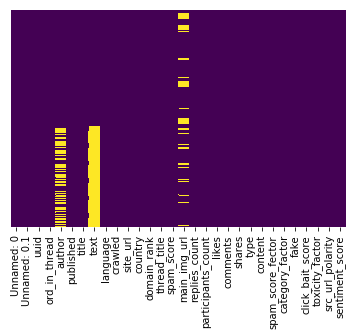

In [6]:
# to check missing values
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

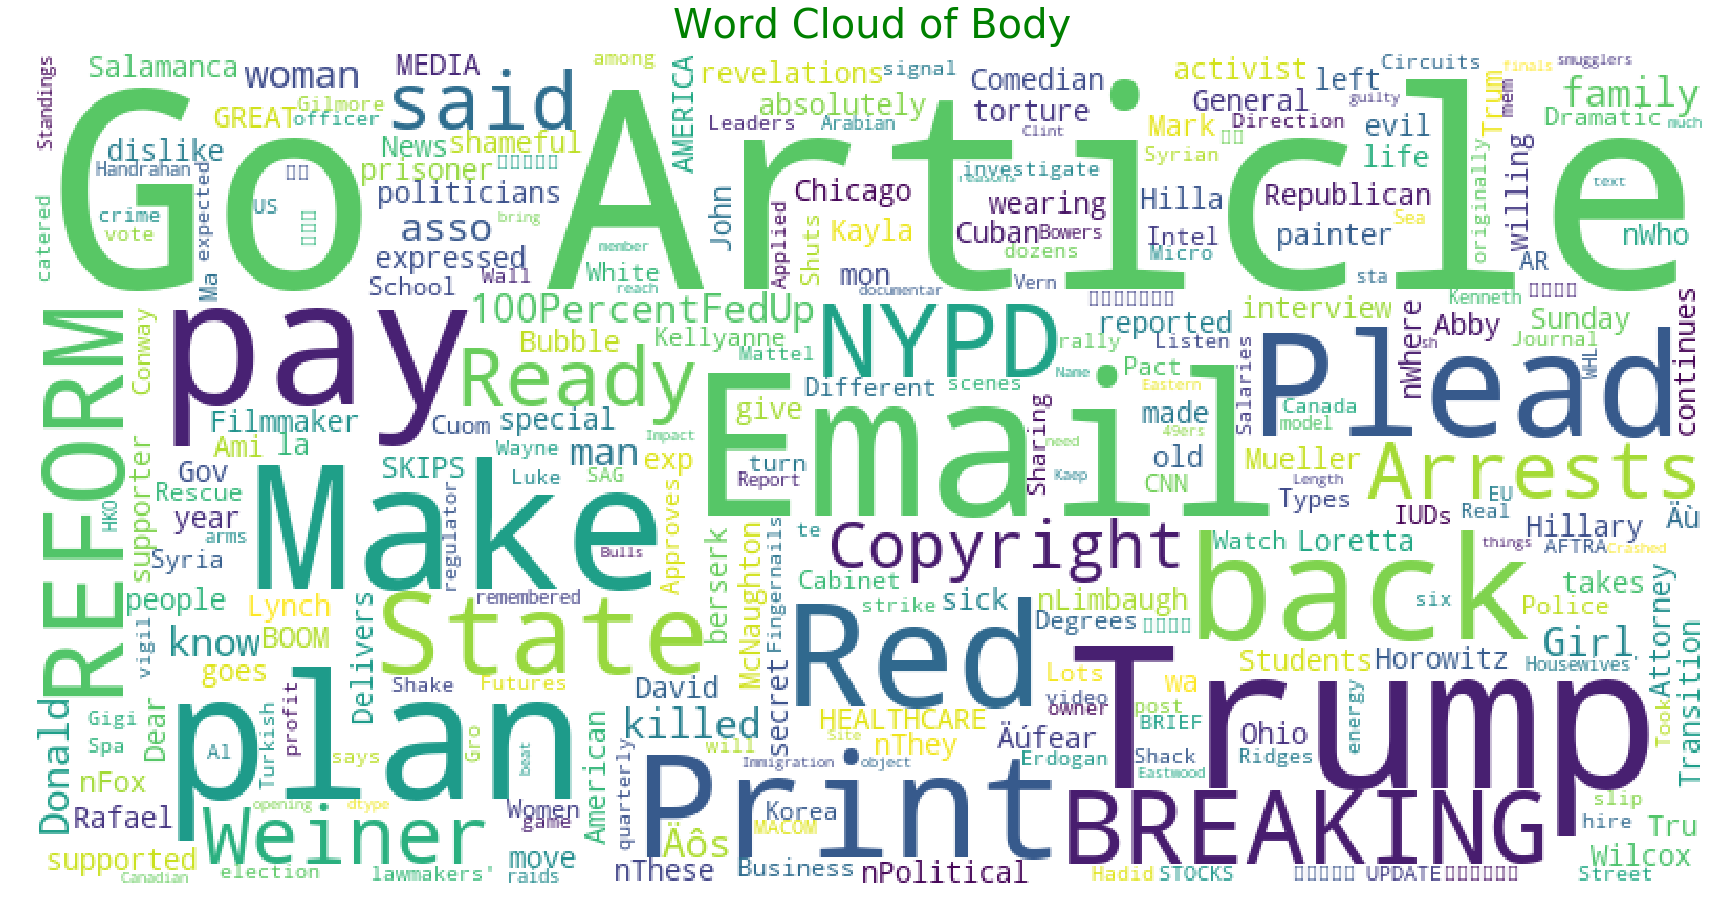

In [14]:
import requests
import PIL
from PIL import Image
from io import BytesIO
from wordcloud import WordCloud, STOPWORDS  #install $ pip install wordcloud

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400
                    #,mask = mask
                         )
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

#response = requests.get('http://?')
#upvote_mask = np.array(Image.open(BytesIO(response.content)))#https://imgurl
plot_wordcloud(df["text"], max_words=300000, max_font_size=300, title="Word Cloud of Body")

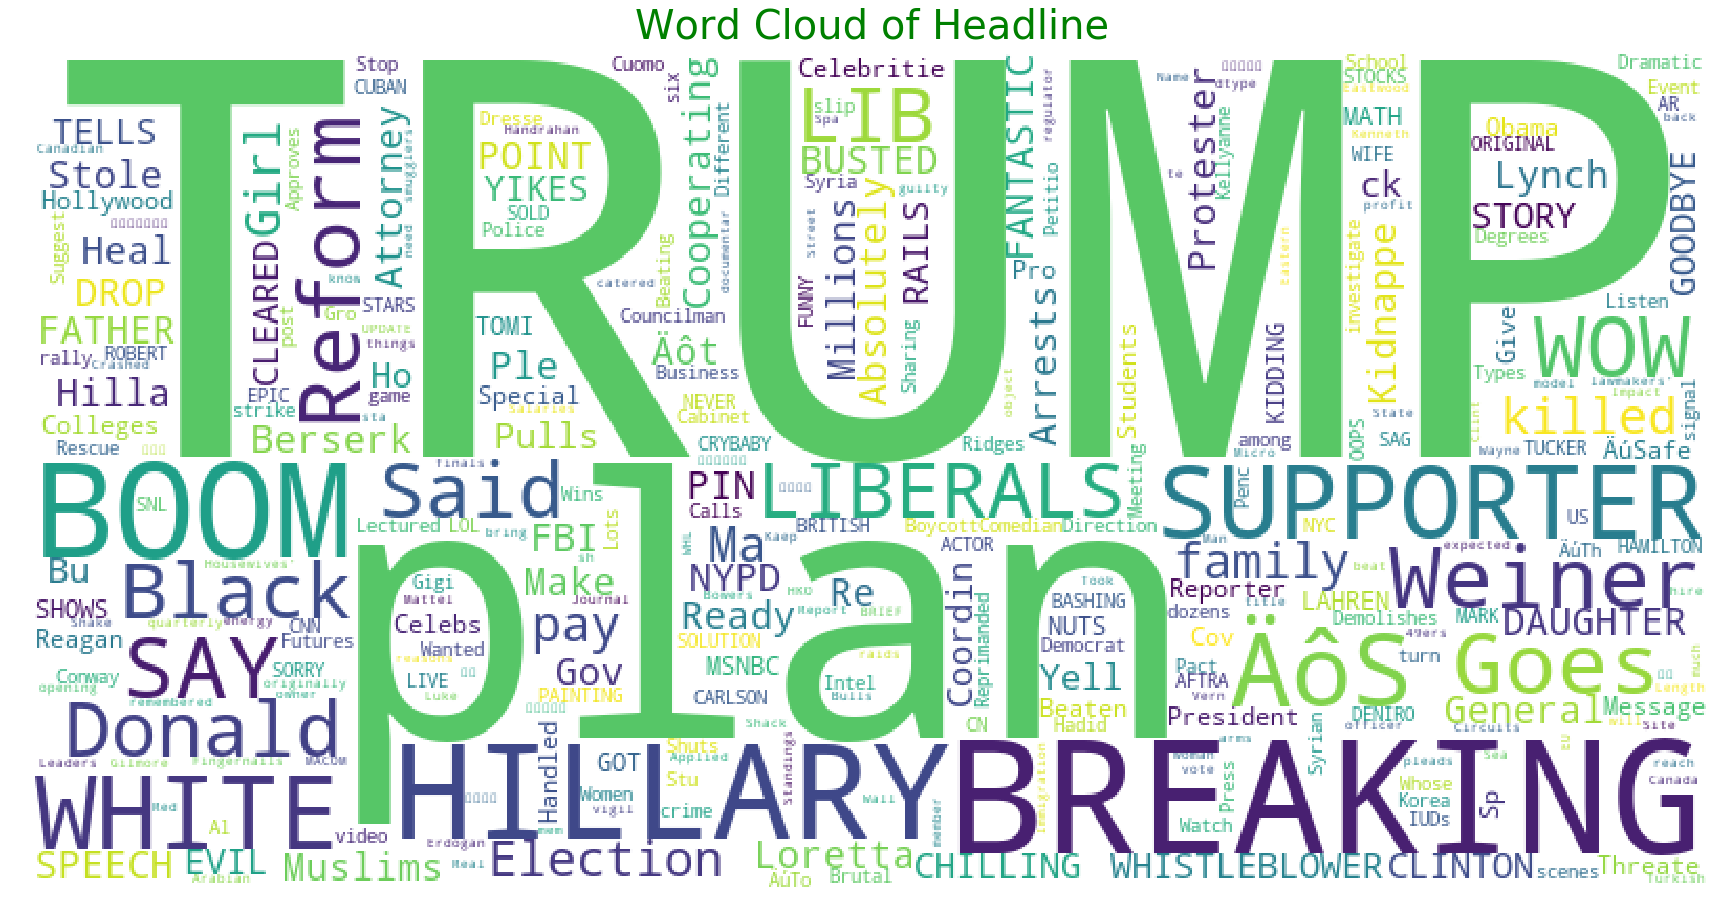

In [16]:
plot_wordcloud(df["title"],  max_words=300000, max_font_size=300, title="Word Cloud of Headline")

In [13]:
##if title/text is empty then use first 50 chars of the text/title.
df['title'] = np.where(df.title.isnull() == True, df.text.str[:50],df.title )
df['text'] = np.where(df.text.isnull() == True, df.title.str[:50],df.text )

## Visualizing Word Vectors (using tSNE & word2Vec)

### LDA with Count Vectorizer

In [57]:
message_docs = df['text'].tolist() #df[df['istoxic']>0].comment_text_clean.tolist() #Can also try Toxic only

In [58]:
import lda
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 20 # number of topics
n_iter = 500 # number of iterations

# vectorizer: ignore English stopwords & words that occur less than 5 times
cvectorizer = CountVectorizer(min_df=5, stop_words='english')
cvz = cvectorizer.fit_transform(message_docs)
# train an LDA model
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)

In [59]:
X_topics = lda_model.fit_transform(cvz)

INFO:lda:n_documents: 3709
INFO:lda:vocab_size: 11771
INFO:lda:n_words: 559301
INFO:lda:n_topics: 20
INFO:lda:n_iter: 500
/Users/gpandey/anaconda3/lib/python3.6/site-packages/lda/utils.py:55: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if sparse and not np.issubdtype(doc_word.dtype, int):
INFO:lda:<0> log likelihood: -6856272
INFO:lda:<10> log likelihood: -5279036
INFO:lda:<20> log likelihood: -5056440
INFO:lda:<30> log likelihood: -4977765
INFO:lda:<40> log likelihood: -4932637
INFO:lda:<50> log likelihood: -4903506
INFO:lda:<60> log likelihood: -4887442
INFO:lda:<70> log likelihood: -4873792
INFO:lda:<80> log likelihood: -4863256
INFO:lda:<90> log likelihood: -4854177
INFO:lda:<100> log likelihood: -4849295
INFO:lda:<110> log likelihood: -4841172
INFO:lda:<120> log likelihood: -4837606
INFO:lda:<130> log likelihood: -4833544
INFO:lda:<140> log likeli

In [60]:
#add a threshold factor that would help filter out unconfident topic assignments. Other wise visualization will be busy
threshold = 0.5
_idx = np.amax(X_topics, axis=1) > threshold  # idx of doc that above the threshold
X_topics = X_topics[_idx]

## Reducing to 2-D with t-SNE

In [61]:
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

# 20-D -> 2-D
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 975 samples in 0.024s...
[t-SNE] Computed neighbors for 975 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 975 / 975
[t-SNE] Mean sigma: 0.120742
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.782333
[t-SNE] Error after 1000 iterations: 0.216664


In [62]:
X_topics.shape

(975, 20)

## Visualzing groups and their keywords

In [63]:
#First we do some setup work (import classes & functions, set params, etc.)
import numpy as np
from bokeh.plotting import save
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import  output_notebook
from bokeh.models import HoverTool

n_top_words = 5 # number of keywords we show

# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

In [64]:
#Then we find the most likely topic for each news
_lda_keys = []
for i in range(X_topics.shape[0]):
  _lda_keys +=  X_topics[i].argmax(),

In [65]:
# get top words for each topic
topic_summaries = []
topic_word = lda_model.topic_word_  # all topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
  topic_summaries.append(' '.join(topic_words)) # append!

In [66]:
output_notebook()

Loading BokehJS ...

In [67]:
# plot the news (each point representing one news)
title = '20 newsgroups LDA viz'
num_example = len(X_topics)

plot_lda = figure(plot_width=1400, plot_height=1100,
                    title=title,
                    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                    x_axis_type=None, y_axis_type=None, min_border=1)
source = ColumnDataSource(
        data=dict(
            x= tsne_lda[:, 0], #tsne_lda.iloc[:, 0],
            y= tsne_lda[:, 1], #tsne_lda.iloc[:, 1],
            content= message_docs[:num_example],
            topic_key= _lda_keys[:num_example],
            c=colormap[_lda_keys][:num_example]
        )
    )

plot_lda.circle('x', 'y', source=source, color='c')
#show(plot_lda)

bokeh.models.renderers.GlyphRenderer(
    id='d491a366-ac19-4235-963d-8e8724d27db4',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='edddb110-483d-4a69-8d48-0afcbcc6aed0',
        callback=None,
        data={'y': {'__ndarray__': 'fqciwe7/e8GRpIDBTZ7ZQOvejMHilIFBRX45wVJdoT/DmR/C43IfwmOxHsIIWqo/B2Ejwp5JJcJcmFq/pA4jwgDOJMIrviLC0/wkwvc+JcI2myxBw7INwi+Yrj8OiSDBQiuVP24BRsGJ9vJAdR/7QLg9zsBjgczAuD3OwLg9zsAAhNDADPoUwm/PAEGQ+B7Ch48BQcSEIcLEhCHCXvsCQcSEIcKOaRXC5QYGwSz+AUHEhCHCuLQYwr3NEsJt/h7CxIQhwsauHcJ0ghbC0bgjwW+YIsHQSBnBAp7TQan81kE6g11AWtUGQEtV/D7ioqxBXzsAQVncb0CgUpTBf2zsQImBpL9TZRNBvf8jv+yzIj+ijz7B++GIQGddi7+FmY4/CODxP150kT+uwT0/FJwPQZwLqUEu848+NU6pQdTnN0HZNnxB/iR9QXunCsH6NmNB2QRPQQMEbkEY4BrBcYJfQVG9G8GL81VBxlHuwfiUp0E7LVdBXEQCwQgQnEEupHZBHocBwUlXBsEbvhNBu/8dwdzoAMIbmHpBqr0FwhP7AUF4uAFBA/IpQN8IEEIAChNCJQy1QH7vDkKPphZCXXEdQvbRJMH/ngpCoEoNQjJrEkKoIxVCKUMJweCOGEKEPwlCW4/6QIxYa0D2qAxCzyEbQpokDELwGxdCLewLQk3jUED2TSjBuQ2TwVzZjMG7rLlA3zO2QAkPq0EtK6pBbFhnQVh1U0HWTmFBLdtqQX8acUENPHtB3VY3QQ6Ko0GulTTBg6k0wTv0aEEGRKBBdvujQdrzQsEeuxjBHmpaQdMSTcHKhxtC72ocQnD5WUG88FdBqWdoQUqOZUFbLWdBVh4xQbFNn0GEDSRB7eUXQlytUEEGToLBXU8zQXg14sHFmMI/BVVNQfqaVUDl0cFA6uwOwluWNUGJibRBH2oXQmBSFkKGOa9BmYFCQYNfUEEWJm5BOAC1QCXhND8z3DJA37ZaQXqRi8Fzda9BcSUswa7IakG3e4DBkyxyQKcrAUE2r+pAetQiP6o/DkLY3htCYxYXQh2HGkJRqAtCABkVQiP+G0IqRq5Bh2oTQtiaCELX2AhC8l4PQvEAFkIoBAlCms8WQpsjFEJlaxVCa40SQpM+FUIneh1CM08QQmbnC0LZIA1CRzAXQps9D0KWoQ1CCm0iQi/aCEKMXhpCKWcQQsgoGUKF6xRCRVsWQsD2DkJ/LBZCN08SQs7kEEKreRZCtSQZQmM6DEIyoqFBJPgYQrH6GkIa1hdCUC0JQlWfEUIz1wtCFmYNQjjuEkJyB7NBaruzQUNcGsEL9uHBh7ASwQoOpUGabBHB8Nokwd494sHlq0XBPAkswQC428GqQeNAPsARwZgmKMEA+YvBpg/iwYgcR8ERPy/B5SDcwZRn7EB4KeLBbtWbQO6XGsG+XOHB3BgDQZbglkAjbhrBcBQBQd0IDUIV0A1CPK0RQhPH5sHklObBPFzjwUGE58E8XOPBPFzjwTxc48E8XOPBS8ZNQDxc48Ho6bVAJTblwddSNME+3TLBPFzjwSEl6cEhJenBuEDgwSEl6cFTauHBoPwWQVNq4cEhJenBV7IBP7P11ECt9Pq/PFzZwS2k3rxU4X7BXjQEQaQD5r5/AKtArh4wvmfyMUEGqWFA2VGAwZw1x8FSJoPB2VGAwdlRgME4Xn8/ZP6CwdlRgMHfMg9C2VGAwRGMCUDrfY6+gcUSP43MVUC/nuJA7Z+vQfsFkEAO0X7BacoZP5zkM0HZUYDBy0mFwQ7RfsFtMiPBVxV/wQNsFcKdHudB2IkVwnTl5kG7TbvBn4ICwlQuw0CdsbvB/HkCwiMtw0D98cPBPoDDwenkGsJXE8PBlsN8QYebG8K++8LBuD18Qe9+AsIsYALCS3m/wSM06UHvWrJBA5S/wR7g6EHG87JBVXS9wbLb3ME18zLBgwYmwZt6NsE0SU5BBNpzQS6FVEG78zdBi5lMwRL+OcGFLDjBUW40wQw9QMGQYjjBfX8+wQkVX0G4+xxCezkZwaJ0KMEq521B+2A+wbHAKsH8NvPBfC6XQIxI10CeZvbBt13fwWXfmD9AlMpAgcUSP4DetkBV0CxA5f20QAvb/UBhS2tAC/60QM6nv8G/EsBAOrGxQBqXG0JCjg/AuacjQCi6GMEmolhA2Q9+vyA9WTzNr2q/lUUfQO2yC7+bLDy+jbNFv6vS5r4C/E2/UuCZv+IoUj4fWoO/sIvsQPQVyz8CxrVAb8suQH/e+z9VlbpAZmkKQI9FhUDS/XtAXF6IQAsPLb/chvs/gWGTv1/LkEDq21LA+m4CQZ3+Nr6/7YFAYybKvs8oi0Ap41NAl348QEYOHD8BVjVB4YfIvnBCnD9tLhE/p6SQQKCqGkA+DJ2/eENGPxM5YD9lMuU+p4HmPPEX2j1Eot4/dsUMQZc7UT9SdRNBOOtvv6VJhkDifQK/psK2QLJd4kDLd05AnIKfP+otS0A/ig3BV8QiwfuWx8Dm4CXBQd/BwCQjI8Hw9yfBi/NjwGHgnD+dIVvAVsOcQZV4OsETMivBOQkswRwDO8GmnP7AL7Y6wcafL8GJxjPBNsx9PxvuNsGX0bnAPNRcwEFMBcGTOFzAKQMHwZpsLcGuEgDBeOozwew2yMB8RijBwX67wE2zicDSEC3BX8k1wWfqk8BcqYQ/Ig4uwTzseMC6LX+/LH3fQL9PiUAoZc5Af7U0wa4JFUH4i+1A1+XpQDAnmEB1775AIPQ3QTDhYEHpw0VBJkjiwctdEkE9lInB3+MHwSYa9MHmvBDC+7gjQikuAMLVFALBJJhoQckvBcJ9CjjBp1HfwA29w8F620hBGK4dv6kvBcJMvRVBUZxAQU6lDsEfFMjAG8v4wSEmFUJAEDrB2VHIPkOy3sE4ss3AyMsIwo8BNEG+EA3B9XXhQabE28DPildBTGfdwZWBT0HmvBDCG8v4weDEDcLN3fbB3oRDQRMZUkEby/jBTNIFwssmj8FFp+xBuacjQPCoEsG8QKVB2VHIPhvL+MHu9uBAeDUWwSSYaEEr3NjARlDQwe2IJUJm0ojBfYz9weIvJUKLvm1Bp1HfwNDGCsF06+VBjaDdQdUtCcIby/jBuUegwFJvWkF7QRtBsqEVvo+MWEEM5wZB1HuoQRIBtUC3MfjA1S0Jwu0sAMKiV65Byi8Fwng1FsHw/hXCk0U4QVlBQ0FMZ93BJYEAwcWi2cDuRRLBPWSLwadR38CoHLNAUm9aQX2M/cHwUhDBYQFkQdlRyD53yEXBjDmCweNVjcH5p1ZB0KRQQQ4HJb/DnKlBp1HfwFJvWkGSCrDA2VHIPuoXQUHKvOZAGUBrQJxJA8KH/nFB8P4Vwl8/pUF9jP3BXl36wRvL+MHT07JATXYOwtiw3UGJ4RhB41WNwQpmaD93NRbBUhaKwdyw2sB0jFhB0KRQQX8/VL+xrvHA1r9gQbKhFb44vwvChaz2wH5cGcKkBNXBpl6GwZ8lG0GYKADC2VHIPtCkUEHtBtpB6RLdQT2D30ETGVJBf6/mwHvbSEHXp6dBgDoVQoJbBsJBR1ZBuacjQFqkE8Lqv+fBWr5rQRpJ3cHGQENBwRMSwdlRyD6JAdzBLmJuQa91D8IUV0rBsDLPwX2M/cHab0pBLkLbwNCkUEFEffTBP+HZwB0nE8J7gaNBrP4SwhvL+MHPv+VBSfWpQMtjLD+CPkdAzm6yQLaFEUIpMNbAW7QKwXo05EE6TgXCzJTQwYd4P8ES07RBkA/qvV

In [68]:
#plot the crucial words for each topic and tooltip
# randomly choose a news (within a topic) coordinate as the crucial words coordinate
topic_coord = np.empty((X_topics.shape[1], 2)) * np.nan
for topic_num in _lda_keys:
  if not np.isnan(topic_coord).any():
    break
  topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

# plot crucial words
for i in range(X_topics.shape[1]):
  plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

show(plot_lda)
# save the plot
#save(plot_lda, '{}.html'.format(title))

In [261]:
fn_dataset = df[['title', 'text']]
fn_dataset.shape

(3709, 2)

In [262]:
fn_dataset = fn_dataset.values
len(fn_dataset)

3709

In [282]:
X_fn = generate_fn_features(fn_dataset, "FakeNewsStance")

In [264]:
X_fn.shape

(3709, 44)

### Predicting Labels based on the earlier FNC model

In [265]:
fn_predicted = [LABELS[int(a)] for a in best_fold.predict(X_fn)]

In [283]:
fn_predicted = np.asarray(fn_predicted)

In [275]:
df['stance'] = np.nan
for i in range(3709):
        df['stance'][i] = fn_predicted[i]
#df['stance'] = fn_predicted[:,0]

/Users/gpandey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/gpandey/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [289]:
df[['title','text','stance']].head(10)

title  \
0  Muslims BUSTED: They Stole Millions In Gov‚Äôt...   
1  Re: Why Did Attorney General Loretta Lynch Ple...   
2  BREAKING: Weiner Cooperating With FBI On Hilla...   
3  PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...   
4  FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...   
5  Hillary Goes Absolutely Berserk On Protester A...   
6  BREAKING! NYPD Ready To Make Arrests In Weiner...   
7  WOW! WHISTLEBLOWER TELLS CHILLING STORY Of Mas...   
8  BREAKING: CLINTON CLEARED...Was This A Coordin...   
9  EVIL HILLARY SUPPORTERS Yell "F*ck Trump"‚Ä¶Bu...   

                                                text     stance  
0  Print They should pay all the back all the mon...    discuss  
1  Why Did Attorney General Loretta Lynch Plead T...    discuss  
2  Red State : \r\nFox News Sunday reported this ...    discuss  
3  Email Kayla Mueller was a prisoner and torture...    discuss  
4  Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...  unrelated  
5  Print Hillary goes absolutely berserk! She exp...    discuss  
6  BREAKING! NYPD Ready To Make Arrests In Weiner...      agree  
7  BREAKING! NYPD Ready To Make Arrests In Weiner...    discuss  
8  \r\nLimbaugh said that the revelations in the ...    discuss  
9  Email \r\nThese people are sick and evil. They...    discuss

### Enriching the original dataset with predicted labels 

In [280]:
df.to_csv('fake_real_dataset_spam_category_clickbait_toxicity_politafln_sentiment_stance.csv')